# Permeability Data analysis

## Import Required Libraries

In [11]:
#importing custom functions
import sys
sys.path.append('/Users/ristomartin/OneDrive/Dropbox/UniStuff/DPhil/Experimental/python_analysis/common_functions')
from custom_functions import *
from common_fits import *

import os
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import iqr, kurtosis, skew
import itertools

## Set Data locations

In [12]:
#What is the root location of the files that you want to analyse
root = '/Users/ristomartin/OneDrive/Dropbox/UniStuff/DPhil/Experimental/'

SSD = '/Volumes/Risto\'s SSD/Math_modelling/output/'

#Data set locations with the root directory selected
data_loc = root+'transport/permeability/280322/'


#What is the root directectory where you want to save everything?
save_loc = root+'python_analysis/permeability/processed_data/'
checkdir(save_loc) #check that processed data directory exists

#for summary tables
summary_save_loc = save_loc+'summaries/'
checkdir(summary_save_loc)

##Create save locations of figures
#figure root
fig_root = save_loc+'figures/'
checkdir(fig_root)

##Fibre diameter data
fibre_dat_loc = root+'ES_PCL_PDO_270219/SEM/bead_free/processed/summary_loc/'

## Constants and experimentally set parameters

In [13]:
##Unit conversions
#cm^3 to m^3
cm3tom3 = 1e-6
#PSI to pa
PSItoPa = 6894.7572931783

##Constants
#Density of water
h20p = 0.9940326 #[g/cm^3]
#Dynamic viscosity of water
mu = 0.0009764 #pa*s
#dynamic viscosity of air
mu_a = 18.13E-6
#Membrane diameter - this will later change depending on membrane thickness
L_dic = {'0ppm':48.86,'1ppm':55.84,'5ppm':62.82,'10ppm':76.78,'25ppm':83.76,'50ppm':111.68} #um

#Membrane diameter - this will later change depending on membrane thickness
#L_dic = {'0ppm':152.29,'1ppm':216.35,'5ppm':157.55,'10ppm':292.8,'25ppm':260.67,'50ppm':154.21} #um

##Experimental parameters
#Diameter of area of membrane exposed to water and pressure (meassured inner diameter of gasket) 
memdia = 38 * 1e-3 #m
mem_area = np.pi*((memdia/2)**2) #m^2
print(mem_area)

#Inlet pressure set at the pressure gauge when connected to dead end filtration cell with membrane and water flowing through
iP = 10 #PSI
iP = iP*PSItoPa #Pa

#Calculate pressure drop in tubes with Hagen–Poiseuille equation (assuming straight rigid tubes)
def hp_dp(mu,Q,L,R):
    dp = (8*mu*L*Q)/(np.pi*(R**4))
    return dp

##Measured characteristics of the inlet and outlet tubes used
###Inlet
#tube length
itube_l = 2.01 #m
#tube radius
itube_r = 6.4e-3/2 #m
###Outlet
#tube length
otube_l = 27e-2 #m
#tube radius
otube_r = 1.67e-3/2 #m

#Equation of a straight line to fit to flux data
def straightline(S,m,c):
    return (m*S)+c

0.0011341149479459152


## Data Analysis

In [14]:
#Make dataframe to store all values
summarydf = pd.DataFrame()

#make a list of all the image files in data_loc
files = [x for x in os.listdir(data_loc) if x.endswith(('csv'))==True]
#Itterating through each of the data files
for f in files:
    #Determine PPM of sample
    ppm = f.split('_')[1]
    ppmint = int(ppm.split('ppm')[0])
    #Determine repeat number
    rep = f.split('_')[3].split('.')[0]
    
    #Get file directory from f
    file = os.path.join(data_loc,f)
    #Open each of the files and read in only time and weight data
    df = pd.read_csv(file,usecols=[2,3,4], on_bad_lines ='skip')
    
    #Remove lines after recording ended
    df = df.drop(df[(df.Time == '0')].index)
    df.dropna(subset = ['Time'], inplace=True)
    
    #Add in data values for when recorded mass is above max of balance
    mass = []
    for n in range(len(df['Header'])):
        if df['Header'][n] == 'SI+':
            mass.append(0)
        else:
            mass.append(float(df['Data'][n]))
    
    ##Convert time into decimal value
    #Make list of times
    times = []
    for t in df['Time']:
        (h, m, s) = t.split(':')
        result = int(h) * 3600 + int(m) * 60 + int(s)
        while result in times:
            result = result+0.142857
        times.append(result)
    ##Having made list of times, bring all values to zero
    #make list of calibrated times
    times0 = []
    #Itterate through each of the times and subtract the first time value to calibrate
    for t in times:
        times0.append(float(t-times[0]))
        
    #Convert mass data into volume of water
    volume = [x/h20p for x in mass]
    
    ##Trim data to only the point at which flow has started and then once flux stops (this is taken as when change is less than 10% per time step)
    #Make marker for start point index
    ix = 0
    #Make marker for end point index
    ex = 0
    #Itterate through volumetric change data
    for i,j in enumerate(volume):
        #As long as havent found the time already take the first index at which mass value is more than 0.1g so flow has started
        if ix == 0:
            if volume[i] > 0.1:
                ix = i
        #As long as flow has been found to start
        if ix != 0:
            #Find then change in volume flux
            dq = volume[i]-volume[i-1]
            #If the change in volume flux between time steps is less than 10% then take this as the end point of region of interest and then end
            if dq/volume[i]<0.01:
                ex = i
                break
    
    #Having found integer values of start and finish point then trim data
    times0 = np.asarray(times0[ix:ex])
    volume = np.asarray(volume[ix:ex])
    
    # #Having got list of times and data plot
    # #create new template for figure
    # fig, ax = plt.subplots()
    # #Plot line graph
    # ax.plot(times0, volume) # plot the line
    # #Set axis labels
    # plt.xlabel('Time (s)')
    # plt.ylabel(r'Volume $(cm^3)$')
    
    #Having isolated change in volume with time data now want to fit a line to data points to get a value of flux (cm^3/s)
    pop, pcov = curve_fit(f=straightline, xdata=times0, ydata=volume,maxfev=1000000)
    # print(pop)
    
    # #Create figure for to plot fitted line to flux data
    # fig, ax = plt.subplots()
    # ax.plot(times0, volume)#, linestyle=model_style[model], color=model_colour[model],label=model)
    # ax.plot(times0, straightline(times0, *pop))#, linestyle=model_style[model], color=model_colour[model],label=model)
    
    #From the gradient of the fitted line we therefore have volumetric flow rate Q [cm^3/s]
    Q = pop[0]   
    #Convert cm^3 to m^3
    Q = Q*cm3tom3
    
    #As have volumetric flux calculate pressure drop along inlet and outlet tubes using measured lengths and radii of each tube and the volumetric flowrate of fluid
    #As gas is entering through inlet tube use dynamic viscosity of air
    idP = hp_dp(mu_a,Q,itube_l,itube_r)
    #As water is leaving through the outlet tube use the dynamic viscosity of water
    odP = hp_dp(mu,Q,otube_l,otube_r)
    #As inlet pressure is set can then calculate the pressure drop over the membrane
    dP = iP-(idP+odP)
    
    #From volumetric flow rate, find flux by dividing by area membrane area
    q = Q/mem_area #m/s
    #Having found instantanious flux now calculate permeability from Darcy's law
    k = (q*mu*L_dic[ppm])/dP #m^2
    #Save calculated permeability to DataFrame
    summarydf = pd.concat([summarydf, pd.DataFrame(data={'permeability':[k],'ppm':[ppmint],'rep':[rep]})], axis=0)#.reindex(summarydf.index)
    
#Reset organise dataframe by ppm and repeat number
summarydf = summarydf.sort_values(['ppm', 'rep'], ascending = (False, True))
#Reset index of dataframe
summarydf = summarydf.reset_index(drop=True)
#Save out summary of change in permeability
summarydf.to_csv(summary_save_loc+'all_permeability'+'.csv',index=False)

print(summarydf)

    permeability  ppm rep
0   9.794276e-09   50   1
1   9.511606e-09   50   2
2   9.706197e-09   50   3
3   7.121067e-09   25   1
4   5.132823e-09   25   2
5   5.243204e-09   25   3
6   6.432761e-09   10   1
7   7.023613e-09   10   2
8   6.838252e-09   10   3
9   5.575682e-09    5   1
10  5.273924e-09    5   2
11  5.452505e-09    5   3
12  4.932394e-09    1   1
13  4.912221e-09    1   2
14  4.835950e-09    1   3
15  4.484384e-09    0   1
16  4.332617e-09    0   2
17  4.462725e-09    0   3


## Make summary of permeability data

In [15]:
#Make a dataframe of permeability summary data
summarydf = pd.DataFrame()

#Open summary of change in permeability
summary = pd.read_csv(summary_save_loc+'all_permeability'+'.csv')
#Get list of all unique values of ppm
ppms = np.asarray(summary['ppm'].explode().unique())

#Itterate through each of the ppm values and calculate the median average and IQR
for p in ppms:
    #Isolate cell number data
    k = summary.loc[(summary['ppm'] == p)]['permeability']#.tolist()
    #Calculate statistics
    median = np.percentile(k.dropna(), 50)
    IQR = iqr(k.dropna())
    quartile_25 = np.percentile(k.dropna(), 25)
    quartile_75 = np.percentile(k.dropna(), 75)
    
    #Append statistics to summay dataframe
    summarydf = pd.concat([summarydf, pd.DataFrame(data={'pyridine_conc':p,'median':[median],'IQR':[IQR],'quartile_25':[quartile_25],
                                                         'quartile_75':[quartile_75]})], axis=0)#.reindex(summarydf.index)

#Save out summary of change in permeability
summarydf.to_csv(summary_save_loc+'permeability_summary'+'.csv',index=False)
print(summarydf)

   pyridine_conc        median           IQR   quartile_25   quartile_75
0             50  9.706197e-09  1.413350e-10  9.608901e-09  9.750236e-09
0             25  5.243204e-09  9.941222e-10  5.188013e-09  6.182135e-09
0             10  6.838252e-09  2.954262e-10  6.635506e-09  6.930933e-09
0              5  5.452505e-09  1.508793e-10  5.363214e-09  5.514094e-09
0              1  4.912221e-09  4.822173e-11  4.874086e-09  4.922307e-09
0              0  4.462725e-09  7.588341e-11  4.397671e-09  4.473555e-09


## Plot change in permeability

   pyridine_conc        median           IQR   quartile_25   quartile_75
0             50  9.706197e-09  1.413350e-10  9.608901e-09  9.750236e-09
1             25  5.243204e-09  9.941222e-10  5.188013e-09  6.182135e-09
2             10  6.838252e-09  2.954262e-10  6.635506e-09  6.930933e-09
3              5  5.452505e-09  1.508793e-10  5.363214e-09  5.514094e-09
4              1  4.912221e-09  4.822173e-11  4.874086e-09  4.922307e-09
5              0  4.462725e-09  7.588341e-11  4.397671e-09  4.473555e-09


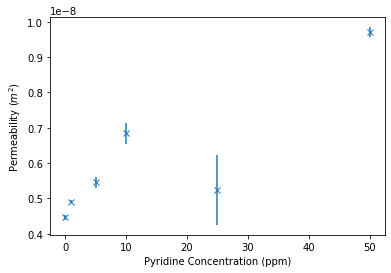

In [16]:
#Open summary of change in permeability
summary = pd.read_csv(summary_save_loc+'permeability_summary'+'.csv')
print(summary)

#Having got list of times and data plot
#create new template for figure
fig, ax = plt.subplots()
#Plot line graph
ax.errorbar(summary['pyridine_conc'],summary['median'],yerr=summary['IQR'], fmt='x') # plot the line
#Set axis labels
plt.xlabel(r'Pyridine Concentration (ppm)')
plt.ylabel(r'Permeability $(m^2)$')
#Set the background colour of the entire plot
fig.patch.set_facecolor('xkcd:white')
#Save figure out
fig.savefig(fig_root+'permeability_pyridine.png', dpi=300)

## Plot change in permeability in terms of fibre diameter

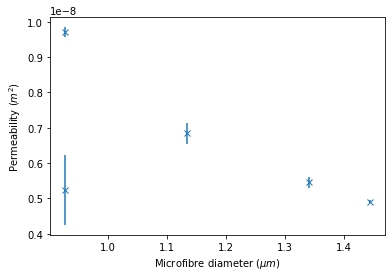

In [17]:
#Open summary of change in permeability
fibre_df = pd.read_csv(fibre_dat_loc+'pyridine_conc'+'.csv')
#Change file name column name to make easier to identify
fibre_df.rename(columns = {list(fibre_df)[0]:'file'}, inplace=True)
#print(fibre_df)
#make column of pyridine concentration in summary df
fibre_df['ppm'] = [float(x.split(',')[1]) for x in list(fibre_df['file'])]
#Reset organise dataframe by ppm and repeat number
fibre_df = fibre_df.sort_values(['ppm'], ascending = (False))
# print(fibre_df)

#Open summary of change in permeability
summary = pd.read_csv(summary_save_loc+'permeability_summary'+'.csv')
#Ensure that permeability data and fibre diameter pyridine concentrations are over same range
summary = summary[summary['pyridine_conc'].isin(fibre_df['ppm'])]
# print(summary)

#Having got fibre diameter now plot
#create new template for figure
fig, ax = plt.subplots()
#Plot line graph
ax.errorbar(fibre_df['median'],summary['median'],yerr=summary['IQR'], fmt='x') # plot the line
#ax.errorbar(fibre_df['median'],summary['median'],yerr=summary['IQR'],xerr=fibre_df['IQR'], fmt='x') # plot the line
#Set axis labels
plt.xlabel(r'Microfibre diameter $(\mu m)$')
plt.ylabel(r'Permeability $(m^2)$')
#Set the background colour of the entire plot
fig.patch.set_facecolor('xkcd:white')
#Save figure out
fig.savefig(fig_root+'permeability_fibre.png', dpi=300)